In [55]:
import os
import sys

sys.path.append('../')

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import gridspec
from matplotlib.colors import Normalize
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torch.optim import Adam
from tqdm import tqdm

from kwave.ktransducer import kWaveGrid
from models.ADMM import ADMM_Batched
from models.APACT import APACT
from models.DAS import DAS, DAS_dual
from models.Joint_Recon import Joint_Recon
from models.PACT import TF_PACT, Wavefront_SoS
from models.Wiener import Wiener_Batched
from utils.data import *
from utils.reconstruction import *
from utils.simulations import get_water_SoS
from utils.visualization import *

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = '../data/'
results_path = '../results/'

### Load Sinogram

Successfully loaded data from "../data/sinogram_simulation_easy.mat".
Successfully loaded data from "../data/sinogram_simulation_uniform.mat".


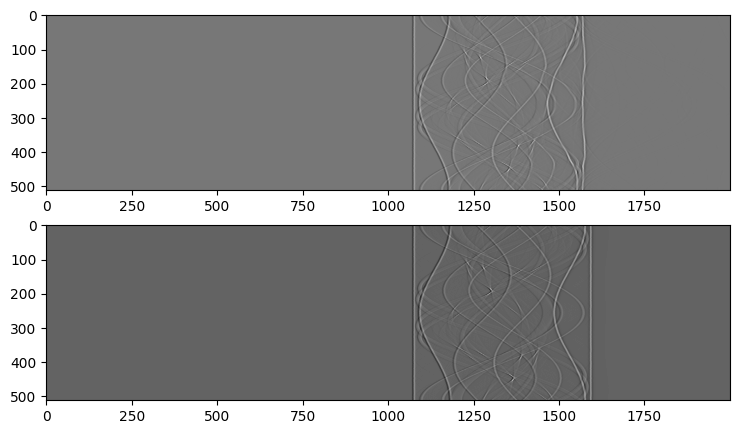

In [56]:
sinogram = load_mat(os.path.join(data_path, 'sinogram_simulation_easy.mat'))
sinogram_uniform = load_mat(os.path.join(data_path, 'sinogram_simulation_uniform.mat'))


plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.imshow(sinogram, cmap='gray')
plt.subplot(2,1,2)
plt.imshow(sinogram_uniform, cmap='gray')
plt.show()

### Load SoS

Successfully loaded data from "../data/SoS_easy.mat".
Successfully loaded data from "../results/SoS_jr.mat".


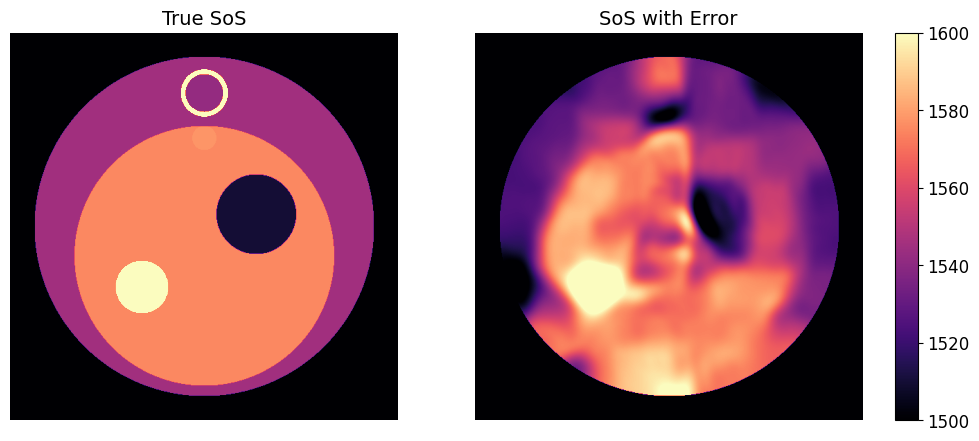

In [57]:
SoS = load_mat(os.path.join(data_path, 'SoS_easy.mat'))
# SoS_error = load_mat(os.path.join(data_path, 'SoS_error.mat'))
SoS_error = load_mat(os.path.join(results_path, 'SoS_jr.mat'))


fig = plt.figure(figsize=(11, 6))
norm = Normalize(vmax=1600, vmin=1500)
plt.subplot(1,2,1)
plt.title('True SoS', fontsize=14)
plt.imshow(SoS, norm=norm, cmap='magma')
plt.axis('off')

ax = plt.subplot(1,2,2)
plt.title('SoS with Error', fontsize=14)
plt.imshow(SoS_error, norm=norm, cmap='magma')
plt.axis('off')
cax = fig.add_axes([ax.get_position().x1+0.03, ax.get_position().y0, 0.02, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm)
cb.ax.set_yticks([1500, 1520, 1540, 1560, 1580, 1600])
cb.ax.tick_params(labelsize=12)

### Preparations

First, we need to define the size and resolution of the image. We also calculate the X and Y coordinates of each pixels in the image.

In [58]:
Nx, Ny = 560, 560
dx, dy = 4e-5, 4e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])
x_vec, y_vec = kgrid.x_vec, kgrid.y_vec
l = 3.2e-3 # Patch size [m].

Next, we define parameters of the single-body SoS for the following wavefront and PSF calculations.

In [59]:
R = 9.8e-3              # Radius of single body [m].
T = 26.0                # Water temperature [C].
v0 = get_water_SoS(T)   # Background SoS [m/s].
v1 = 1558#1567.3             # Avergae SoS in single body [m/s].
print(v0, v1)

1499.3632858457756 1558


Calculate the gaussian kernel which smooths the image boundaries when merging image patches.

In [60]:
fwhm = 1.5e-3 # [m]
sigma = fwhm / 4e-5 / np.sqrt(2*np.log(2))
gaussian_window = torch.tensor(gaussian_kernel(sigma, 80)).cuda()

Initialize the delay-and-sum model.

In [61]:
das = DAS(R_ring=0.05, N_transducer=512, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, mode='zero')
das.cuda()
das.eval()

DAS()

### Uniform SoS

In [62]:
with torch.no_grad():
    gt = das(sinogram=torch.tensor(sinogram_uniform).cuda(), 
             v0=torch.tensor(v0).cuda(),
             d_delay=torch.zeros(1).cuda(),
             ring_error=torch.zeros(1).cuda()).detach().cpu().numpy()

In [63]:
save_mat(os.path.join(results_path, 'gt_simulation.mat'), gt.swapaxes(0,1), 'img')

Successfully saved data to "../results/gt_simulation.mat".


### Conventional DAS

In [64]:
with torch.no_grad():
    rec_das = das(sinogram=torch.tensor(sinogram).cuda(),
                  v0=torch.tensor(1510.5).cuda(),
                  d_delay=torch.zeros(1).cuda(),
                  ring_error=torch.zeros(1).cuda()).detach().cpu().numpy()

In [65]:
save_mat(os.path.join(results_path, 'das_simulation_easy.mat'), rec_das.swapaxes(0,1), 'img')

Successfully saved data to "../results/das_simulation_easy.mat".


### Dual SoS DAS

In [66]:
das_dual = DAS_dual(R_ring=0.05, N_transducer=512, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, R_body=R, center=(0.0, 0.0), mode='zero')
das_dual.cuda()
das_dual.eval()

DAS_dual()

In [67]:
with torch.no_grad():
    rec_das_dual = das_dual(sinogram=torch.tensor(sinogram).cuda(),
                            v0=torch.tensor(v0).cuda(),
                            v1=torch.tensor(v1).cuda(),
                            d_delay=torch.zeros(1).cuda(), 
                            ring_error=torch.zeros(1).cuda()).detach().cpu().numpy()

In [68]:
save_mat(os.path.join(results_path, 'das_dual_simulation_easy.mat'), rec_das_dual.swapaxes(0,1), 'img')

Successfully saved data to "../results/das_dual_simulation_easy.mat".


### APACT

In [69]:
# delays_apact = np.arange(-8e-4, 8e-4, 0.5e-4) # Delay distances [m].

# apact = APACT(delays=delays_apact, dc_range=[-2e-4, 1.6e-4], amp=3.2e-4, step=4e-5, data_path='./TF_simulation/', device=device)
# apact.cuda()
# apact.eval()

In [70]:
# img_stack = []
# with torch.no_grad():
#     for d_delay in tqdm(delays_apact):
#         recon = das(sinogram=torch.tensor(sinogram).cuda(), 
#                     v0=torch.tensor(1510.5).cuda(),
#                     d_delay=torch.tensor(d_delay).cuda(),
#                     ring_error=torch.zeros(1).cuda())
#         img_stack.append(recon)
# img_stack = torch.stack(img_stack, dim=0)

In [71]:
# def deconv_full_apact(model, img_stack, gaussian_window):
#     rec_apact = torch.zeros_like(img_stack[0]).cuda()
#     with torch.no_grad():
#         for idx in tqdm(range(625)):
#             i, j = idx // 25, idx % 25
#             obs = img_stack[:,20*i:20*i+80, 20*j:20*j+80] * gaussian_window
#             obs = obs.unsqueeze(0).cuda()
#             rec, _, _, _ = model(obs)
#             rec_apact[20*i:20*i+80, 20*j:20*j+80] += rec.squeeze(0).squeeze(0)
#     return rec_apact.detach().cpu().numpy()

# rec_apact = deconv_full_apact(apact, img_stack, gaussian_window)

In [72]:
# save_mat(os.path.join(results_path, 'apact_simulation_easy.mat'), rec_apact.swapaxes(0,1), 'img')

### Deconvolution with Single Body PSFs

In [73]:
n_delays = 32
delays = np.linspace(-8e-4, 8e-4, n_delays)

In [74]:
img_stack = []
with torch.no_grad():
    for d_delay in tqdm(delays):
        recon = das(sinogram=torch.tensor(sinogram).cuda(), 
                    v0=torch.tensor(v0).cuda(),
                    d_delay=torch.tensor(d_delay).cuda(),
                    ring_error=torch.zeros(1).cuda())
        img_stack.append(recon)
img_stack = torch.stack(img_stack, dim=0)

100%|██████████| 32/32 [00:02<00:00, 10.95it/s]


In [75]:
def deconv_full(img_stack, SoS, gaussian_window, delays, attention='uniform'):
    wavefront_sos = Wavefront_SoS(R, v0, x_vec, y_vec, n_points=180)
    wavefront_sos.cuda()
    wavefront_sos.eval()
    
    tf_pact = TF_PACT(n_points=160, l=6.4e-3, n_delays=delays.shape[0])
    tf_pact.cuda()
    tf_pact.eval()

    wiener = Wiener_Batched(lam=0e-3, order=1.2, device=device)
    wiener.cuda()
    wiener.eval()
    
    img_stack /= img_stack.abs().mean()
    rec_full = torch.zeros_like(img_stack[0]).cuda()
    SoS = torch.tensor(SoS, dtype=torch.float64).cuda()
    with torch.no_grad():
        for idx in tqdm(range(625)):
            i, j = idx // 25, idx % 25
            x, y = (j-12)*l / 4, (12-i)*l / 4
            thetas, wfs = wavefront_sos(torch.tensor(x).cuda(), torch.tensor(y).cuda(), SoS)
            tf = tf_pact(torch.tensor(delays).cuda().view(1,-1,1,1), thetas, wfs)
            obs = img_stack[:,20*i:20*i+80, 20*j:20*j+80]
            _, C0 = get_r_C0(i, j, R, l, v0, v1)
            weights = torch.tensor(get_weights(C0, delays, attention)).cuda()
            obs, tf = obs * torch.sqrt(weights), tf * torch.sqrt(weights) # Apply attention weights to different channels.
            obs = obs.unsqueeze(0) * gaussian_window
            rec = wiener(obs, tf)
            rec_full[20*i:20*i+80, 20*j:20*j+80] += rec.squeeze(0).squeeze(0)
    return rec_full.detach().cpu().numpy()

rec_deconv = deconv_full(img_stack, SoS, gaussian_window, delays)
rec_jr = deconv_full(img_stack, SoS_error, gaussian_window, delays)
# rec_deconv_onehot = deconv_full(img_stack, SoS, gaussian_window, delays, 'onehot')

100%|██████████| 625/625 [00:02<00:00, 221.15it/s]


In [76]:
save_mat(os.path.join(results_path, 'deconv_simulation_easy.mat'), rec_deconv.swapaxes(0,1), 'img')
save_mat(os.path.join(results_path, 'jr_simulation_easy.mat'), rec_jr.swapaxes(0,1), 'img')
# save_mat(os.path.join(results_path, 'deconv_onehot_simulation_easy.mat'), rec_deconv_onehot.swapaxes(0,1), 'img')

Successfully saved data to "../results/deconv_simulation_easy.mat".
Successfully saved data to "../results/jr_simulation_easy.mat".


### Visualization

Load and normalize images.

In [77]:
IP_img = load_mat(os.path.join(data_path, 'IP.mat'))
gt = load_mat(os.path.join(results_path, 'gt_simulation.mat'))
rec_das = load_mat(os.path.join(results_path, 'das_simulation_easy.mat'))
rec_das_dual = load_mat(os.path.join(results_path, 'das_dual_simulation_easy.mat'))
rec_apact = load_mat(os.path.join(results_path, 'apact_simulation_easy.mat'))
rec_deconv = load_mat(os.path.join(results_path, 'deconv_simulation_easy.mat'))
rec_jr = load_mat(os.path.join(results_path, 'jr_simulation_easy.mat'))    
rec_deconv_onehot = load_mat(os.path.join(results_path, 'deconv_onehot_simulation_easy.mat'))

Successfully loaded data from "../data/IP.mat".
Successfully loaded data from "../results/gt_simulation.mat".
Successfully loaded data from "../results/das_simulation_easy.mat".
Successfully loaded data from "../results/das_dual_simulation_easy.mat".
Successfully loaded data from "../results/apact_simulation_easy.mat".
Successfully loaded data from "../results/deconv_simulation_easy.mat".
Successfully loaded data from "../results/jr_simulation_easy.mat".
Successfully loaded data from "../results/deconv_onehot_simulation_easy.mat".


In [78]:
[IP_img, gt, rec_das, rec_das_dual, rec_apact, rec_deconv, rec_jr, rec_deconv_onehot] = \
    [standardize(img) for img in [IP_img, gt, rec_das, rec_das_dual, rec_apact, rec_deconv, rec_jr, rec_deconv_onehot]]

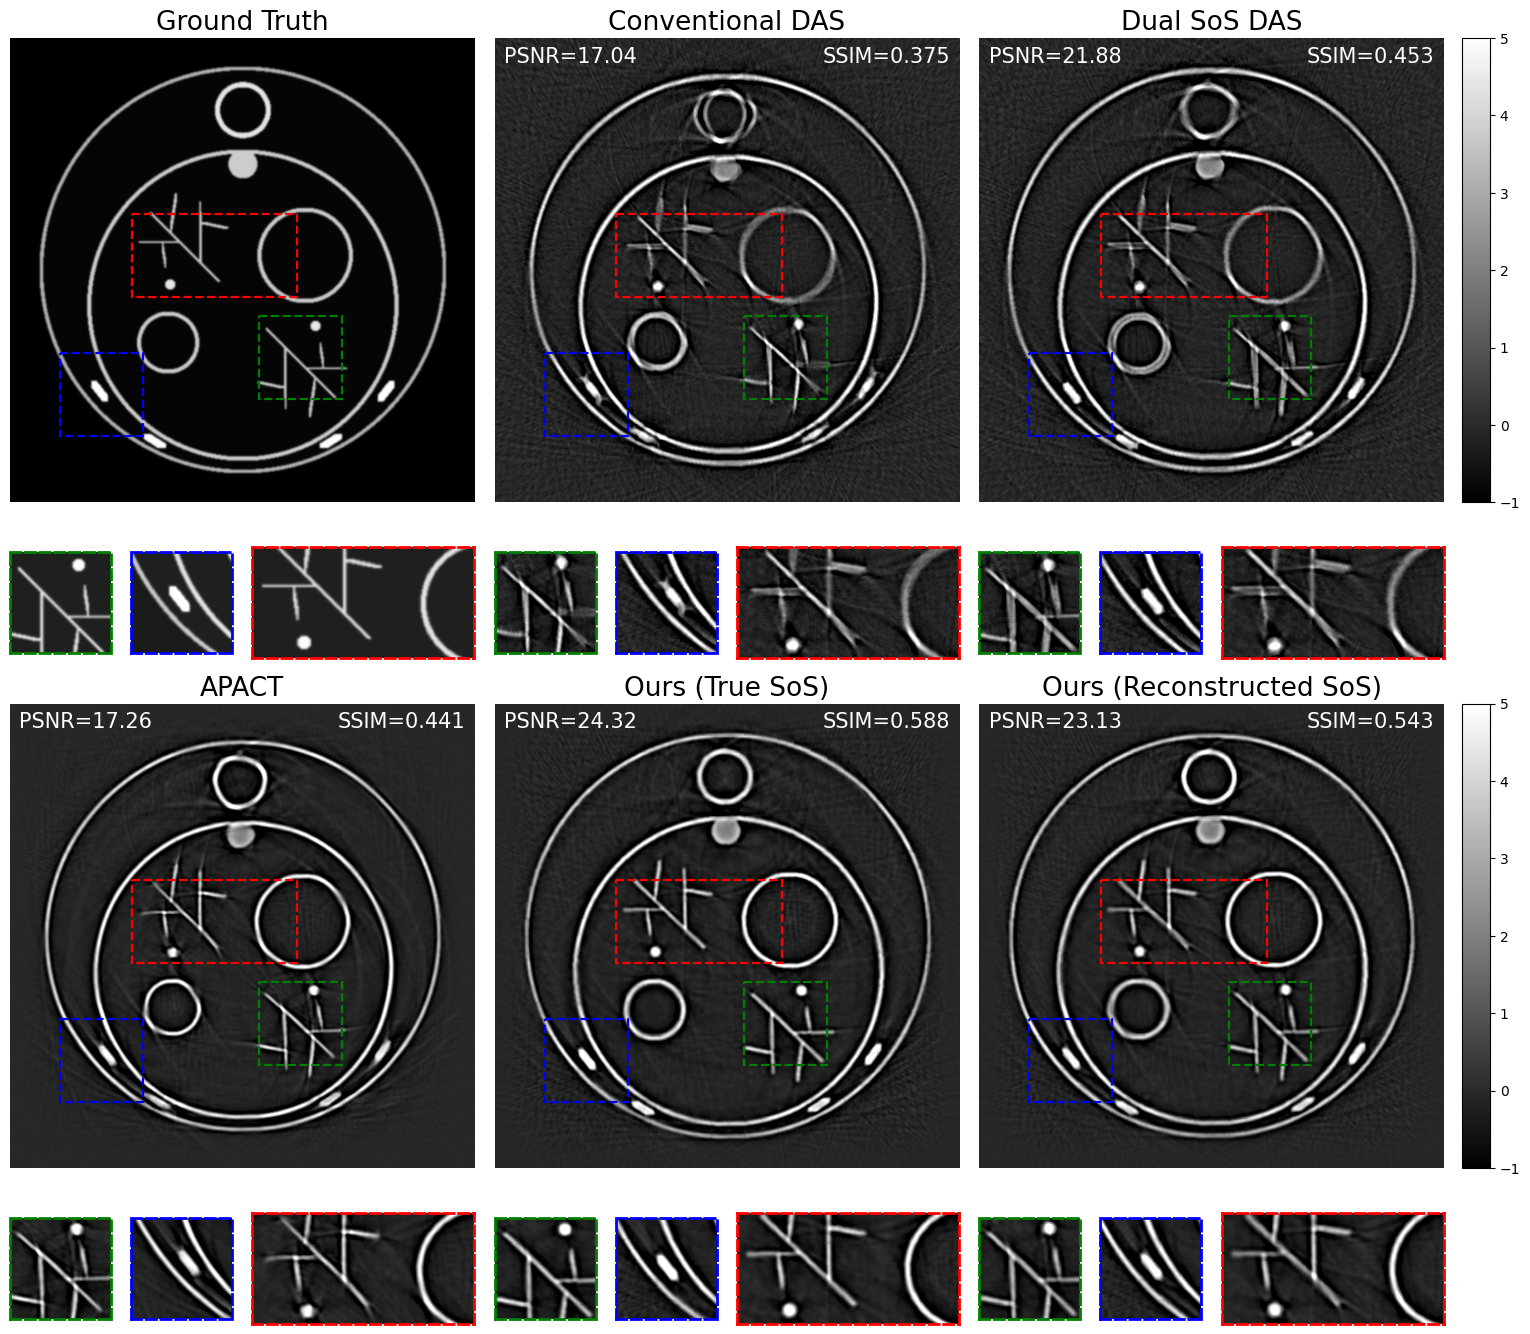

In [79]:
patches = [(335, 300, 100, 100, 'green'), (380, 60, 100, 100,'blue'), (212, 146, 100, 200, 'red')]

fig = plt.figure(figsize=(18.5, 17))
gs = gridspec.GridSpec(10, 12)
# norm = matplotlib.colors.Normalize(vmax=1, vmin=0)
norm = Normalize(vmax=5, vmin=-1)
for idx, (rec_full, method) in enumerate(zip([IP_img, rec_das, rec_das_dual, rec_apact, rec_deconv, rec_jr], \
                                             ['Ground Truth', 'Conventional DAS', 'Dual SoS DAS', 'APACT', 'Ours (True SoS)', 'Ours (Reconstructed SoS)'])):
    ax = plt.subplot(gs[(idx//3)*5:(idx//3)*5+4,(idx%3)*4:(idx%3+1)*4])
    if idx == 0:
        plt.imshow(IP_img, cmap='gray', norm=Normalize(vmax=IP_img.max(), vmin=IP_img.min()))
    else:
        plt.imshow(rec_full, cmap='gray', norm=norm)
    plt.title(method, fontsize=19)
    if idx > 0:
        plt.title('PSNR={:.2f}'.format(psnr(IP_img, rec_full, data_range=10)), loc='left', x=0.02, y=0.93, fontsize=15, color='white')
        plt.title('SSIM={:.3f}'.format(ssim(IP_img, rec_full, data_range=10)), loc='right', x=0.98, y=0.93, fontsize=15, color='white')
    plt.axis('off')
    if idx % 3 == 2:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.015, ax.get_position().height])
        cb = plt.colorbar(cax=cax)
    for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.6, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[(idx//3)*5+4:(idx//3)*5+5,(idx%3)*4+k:(idx%3)*4+k+1+(k==2)])
        plt.imshow(rec_full[x:x+h, y:y+w], cmap='gray', norm=norm)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(2)
            ax2.spines[loc].set_linestyle('--')

In [80]:
plt.imsave(os.path.join('../figures', 'rec_das_simulation.png'), rec_das, cmap='gray', vmin=-1, vmax=5)
plt.imsave(os.path.join('../figures', 'rec_jr_simulation.png'), rec_jr, cmap='gray', vmin=-1, vmax=5)

In [81]:
# fig = plt.figure(figsize=(9, 4.5))
# for idx, (rec_full, attention) in enumerate(zip([rec_deconv, rec_deconv_onehot], ['Uniform', 'Onehot'])):
#         ax = plt.subplot(1,2,idx+1)
#         plt.imshow(rec_full, cmap='gray', norm=norm)
#         plt.title(attention, fontsize=20)
#         plt.xticks([])
#         plt.yticks([])
# plt.tight_layout()